# 3章Policy Function Iteration

In [264]:
# ライブラリのインポート
import numpy as np
from collections.abc import Callable
from scipy.optimize import fmin
# from numpy.polynomial.chebyshev import Chebyshev
from scipy.interpolate import RectBivariateSpline
import copy
import matplotlib.pyplot as plt

### ステップ 1&2&3&4&5
1. グリッド生成
2. カリブレーションしたパラメータの値を設定
3. 収束の定義
4. 確率変数 $A = \{A_{good}, A_{bad}\}$を定義
5. 遷移確率行列 $P$を定義

In [265]:
# パラメータを定義したクラス
# 再代入されたりしないようにただの変数とは区別して定義する
class Parameters():
    '''
    モデルのパラメータをまとめたクラス
    '''
    def __init__(self, beta: float, gamma: float, alpha: float, delta: float,
                A: np.ndarray, P: np.ndarray,
                kmax: float, kmin: float, ksize: int,
                epsilon: float, max_iter: int):
        self.beta = beta; self.gamma = gamma; self.alpha = alpha; self.delta = delta
        self.A = A; self.P = P
        self.kmax = kmax; self.kmin = kmin; self.ksize = ksize
        self.epsilon = epsilon; self.max_iter = max_iter
        self.k_grid = np.linspace(start = self.kmin, stop = self.kmax, num  = self.ksize)

In [266]:
params = Parameters(alpha = 0.4, beta = 0.96, gamma = 1.0, delta = 1.0,
                    kmax = 0.5, kmin = 0.025, ksize = 20,
                    epsilon = 1e-5, max_iter = 1000,
                    A = np.array([0.99, 1.01]),
                    P = np.array([[0.875, 0.125],[0.125, 0.875]]),
                    )

### ステップ6. 政策関数$k'=g^{[0]}(k_i,z_l)$をguess

- 今回は富の関数の半分の値とする

In [267]:
# 富の関数
def wealth(params: Parameters, k: float, a: float) -> float:
    return a * (k**params.alpha) + (1 - params.delta) * k

In [268]:
def guess_pf(params: Parameters) -> np.ndarray:
    mesh_k, mesh_a = np.meshgrid(params.k_grid, params.A, indexing = 'ij')
    kprime_g0_grid = (mesh_a * (mesh_k ** params.alpha) + (1 - params.delta) )/2
    return kprime_g0_grid

In [269]:
guess_pf_grid = guess_pf(params)

### ステップ7. 当て推量した政策関数を用いて価値関数を計算する

In [270]:
# 効用関数
def utility(params: Parameters, c: float):
    if params.gamma == 1.0:
        return np.log(c)

    return (c ** (1 - params.gamma)) / (1 - params.gamma)

In [271]:
# utility関数のテスト あっていれば何も出力されない
assert utility(params, 1.0) == 0.0
assert utility(params, 2.0) == np.log(2.0)
assert utility(params, 0.5) == np.log(0.5)

In [272]:
# ベルマン方程式の右辺
def rhs_bellman(params: Parameters, wealth: float, kprime: float, a: float,
                utility: Callable, vf: Callable[[float, float], float]):
    Aidx = np.where(params.A == a)[0][0]
    for k, aprime in enumerate(params.A):
        expected_vf =+ params.P[Aidx, k] * vf(kprime, aprime)
    rhs = utility(params, wealth - kprime) + params.beta * expected_vf
    return rhs

In [273]:
# rhs_bellmanのテスト
assert rhs_bellman(params, 1.0, 0.5, 1.01, utility, lambda x, y: 0.0) == np.log(0.5)
assert rhs_bellman(params, 1.0, 0.5, 0.99, utility, lambda x, y: 0.0) == np.log(0.5)

In [274]:
# 政策関数を所与として価値関数を更新する関数
def update_vf(params: Parameters, loops: int, pf_grid: np.ndarray, utility: Callable,
                wealth: Callable, rhs_bellman: Callable,
                vf_old: Callable):
    vf_new_grid = np.zeros((params.ksize, params.A.size))
    loop = 0
    while loop < loops: 
        for i, K in enumerate(params.k_grid):
            for l, a in enumerate(params.A):
                vf_new_grid[i, l] = rhs_bellman(params, wealth(params, K, a), pf_grid[i, l], a, utility, vf_old)
        vf_new = RectBivariateSpline(params.k_grid, params.A, vf_new_grid, kx = 1, ky = 1)
        vf_old = copy.copy(vf_new)
        loop += 1
    return vf_new

In [275]:
# 価値関数を所与として政策関数を更新する関数
def update_pf(params: Parameters, calc_wealth: Callable,
            rhs_bellman: Callable, utility: Callable, vf: Callable):
    pf_new_grid = np.zeros((params.ksize, params.A.size))
    
    def wrap_rhs_bellman(kprime: float, params: Callable, wealth: float,
                        a: float, utility: Callable, vf: Callable):
        # 消費が負になる場合はペナルティを与える
        if wealth < kprime:             
            return 10**5 + kprime
        return - rhs_bellman(params, wealth, kprime, a, utility, vf)
    
    for i, K in enumerate(params.k_grid):
        for l, a in enumerate(params.A):
            wealth = calc_wealth(params, K, a)
            pf_new_grid[i, l] = fmin(wrap_rhs_bellman,
                                    x0 = [params.k_grid[i]],
                                    args = (params, wealth, a, utility, vf),
                                    disp=False)
    return pf_new_grid

In [276]:
# 収束の計算をする関数
def is_converged(params: Parameters, vf_old, vf_new):
    np_vf_old = np.frompyfunc(vf_old, 2, 1)
    np_vf_new = np.frompyfunc(vf_new, 2, 1)
    # k_grid行A列の行列を生成
    KK, AA = np.meshgrid(params.k_grid, params.A, indexing = "ij")
    vf_old_grid = np_vf_old(KK, AA)
    vf_new_grid = np_vf_new(KK, AA)
    diff = np.max(np.abs(vf_new_grid - vf_old_grid))
    print(diff)
    if diff < params.epsilon:
        return True
    return False

In [277]:
def PFI(params: Parameters, update_vf: Callable, update_pf: Callable,
        is_converged: Callable, utility: Callable, wealth: Callable, rhs_bellman: Callable, 
        old_pf_grid):
    # 価値関数の当て推量
    vf_old = lambda k, a: k+a
    vf_new = lambda k, a: k+a + 1

    new_pf_grid = np.zeros((params.k_grid.size, params.A.size))
    
    loop = 0
    while is_converged(params, vf_old, vf_new) != True:

        vf_old = copy.copy(vf_new)
        # 当て推量した政策関数を用いて, 価値関数を計算
        vf_new = update_vf(params, params.max_iter, old_pf_grid, utility,
                            wealth, rhs_bellman, vf_old)
        
        # 新しい価値関数を用いて政策関数を計算する
        new_pf_grid = update_pf(params, wealth, rhs_bellman, utility, vf_new)
        
        # 新しく得られた政策関数を用いて価値関数を再計算する
        vf_new = update_vf(params, params.max_iter, new_pf_grid, utility,
                            wealth, rhs_bellman, vf_new)
        
        # kprime_g0_grid = kprime_g1_grid
        loop += 1
        print(f'loops {loop}')

    return vf_new, new_pf_grid, params

In [278]:
vf_new, new_pf_grid, params = PFI(params, update_vf, update_pf, is_converged, utility,
                                    wealth, rhs_bellman, guess_pf_grid)

1.0000000000000002


/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_28962/1589754197.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vf_new_grid[i, l] = rhs_bellman(params, wealth(params, K, a), pf_grid[i, l], a, utility, vf_old)
/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_28962/2968808564.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pf_new_grid[i, l] = fmin(wrap_rhs_bellman,


loops 1
[[62.1588838]]
loops 2
[[0.]]


In [279]:
print(new_pf_grid)

[[-1.58456325e+27  7.50000000e-02]
 [-3.16912650e+27  1.00000000e-01]
 [-4.75368975e+27  1.24980469e-01]
 [-6.33825300e+27  1.30625000e-01]
 [-7.92281625e+27  1.50000000e-01]
 [-9.50737950e+27  1.53867188e-01]
 [-1.10919428e+28  1.75000000e-01]
 [-1.26765060e+28  1.75000000e-01]
 [-1.42610693e+28  1.85009766e-01]
 [-1.58456325e+28  2.00000000e-01]
 [-1.74301958e+28  2.00019531e-01]
 [-1.90147590e+28  2.06953125e-01]
 [-2.05993223e+28  2.24960937e-01]
 [-2.21838855e+28  2.24970703e-01]
 [-2.37684488e+28  2.25000000e-01]
 [-2.53530120e+28  2.28750000e-01]
 [-2.69375753e+28  2.45952148e-01]
 [-2.85221385e+28  2.49960938e-01]
 [-3.01067018e+28  2.50024414e-01]
 [-3.16912650e+28  2.50000000e-01]]


In [280]:
def plot_pf(params: Parameters, pf_grid: np.ndarray):
    fig, ax = plt.subplots()
    for l, a in enumerate(params.A):
        ax.plot(params.k_grid, pf_grid[:, l], label = f"a = {a}")
    ax.set(xlabel = 'k', ylabel = 'kprime', title = 'Policy Function')
    ax.legend()
    plt.show()

In [281]:
def plot_vf(params: Parameters, vf: Callable):
    fig, ax = plt.subplots()
    for l, a in enumerate(params.A):
        ax.plot(params.k_grid, vf(params.k_grid, a), label = f"a = {a}")
    ax.set(xlabel = 'k', ylabel = 'V(k)', title = 'Value Function')
    ax.legend()
    plt.show()

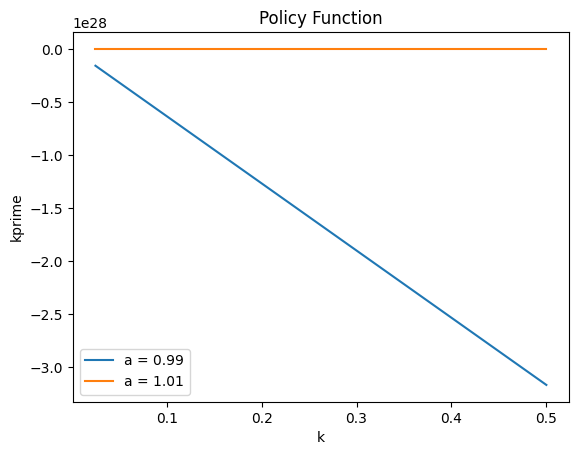

In [282]:
# kprime_g1_grid をプロット
plot_pf(params, new_pf_grid)

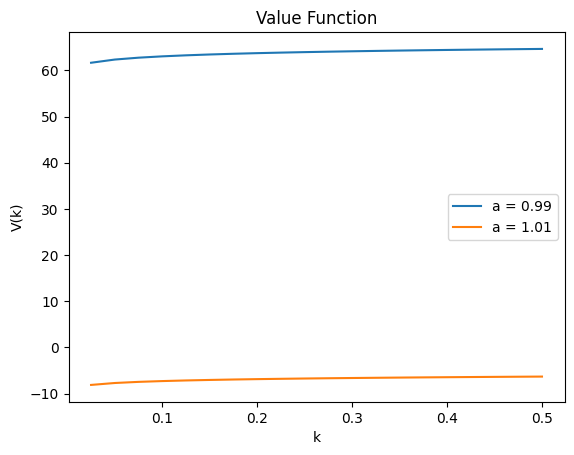

In [283]:
# 収束後の価値関数をプロット
plot_vf(params, vf_new)

### p78 図3.6の価値関数と政策関数をプロット

In [263]:
%reset -f